In [1]:
GPU = True  #set to True to use GPU for XGboost 
OPTUNA = False #set to True to run Optuna first, false to use saved hyperparameters
MODEL_NAME = "xgboost"
#MODEL_NAME = "lightgbm"

## Model Testing

Runs Gradient-Boosted Tree (gbt) training models (option to select Xgboost or Lightgbm) and logs the key information to Neptune.ai. 

(Originally 2 notebooks were utilized, one for XGB and one for LGB, but these were converted to this single notebook for convenience. Simple "if" statements are used to select the small differences in code when choosing one or the other.)

If Optuna is set to True, then hyperparameters are tuned first and used for the test run. Otherwise, the current best hyperparameters are kept in a JSON file and are utilized instead. If Optuna is utilized, then a separate Neptune logging run is initialized to record the key tuning data.

Various metrics are calculated and recorded. AUC will likely be of primary interest since the eventual goal is to compare win-lose probabilities against betting odds, not necessarily to accurately predict the winner for each game. Accuracy is an interesting metric though, and is recorded as well.

Along with standard built-in measures for feature importance using weight and gain, Shapley value feature importances are also generated to give a different perspective on feature importances. These Shapley feature importances are local to the specific data run through the model and therefore can be used in some form of adversarial evaluation, such as train data vs test data and/or test split 1 vs test split 2 (see below.)

This model evaluation does include splitting the test set into "early" season data (Test1) and "later" season data (Test2) and comparing the performance on each.

Process flow:

- load data that has gone through feature engineering and selection
- initialize Neptune.ai logging run
- set key options
- fix datatypes for correct date format and decrease memory footprint
- perform any categorical encoding required for XGB or LGB
- drop any features that are not useful and set the target
- load hyperparameters from JSON file or re-tune them with Optuna
- train the model with stratified K-fold cross validation
- output key metrics and feature importances for Out-of-Fold validation set
- run the model on the test/validation set
- output key metrics and feature importances for test/validation data
- split the test/validation data into Test1 (early season) and Test2 (later season)
- run model on each
- output key metrics and feature importances for each
- perform model evaluation, comparing train vs test and test1 vs test2
- if re-tuned hyperparameters are better (per human inspection) then manually run the function to save these as new defaults. (These re-tuned hyperparameters are always logged at Neptune.ai and can be retrieved whenever necessary, but human interaction is required to establish new default parameters because various experiments might not be optimal in the long run.)



In [2]:
import os

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

from sklearn.model_selection import (
    StratifiedKFold, 
    TimeSeriesSplit,
)

import xgboost as xgb
print('XGB version:', xgb.__version__)

import lightgbm as lgb
from lightgbm import (
    early_stopping,
    log_evaluation,
)
print('LGB version:', lgb.__version__)

import optuna
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances,
)

from src.optuna_objectives import (
    XGB_objective,
    LGB_objective,
)

import neptune.new as neptune
from neptune.new.integrations.xgboost import NeptuneCallback
from neptune.new.integrations.lightgbm import (
    NeptuneCallback as LGB_NeptuneCallback, 
    create_booster_summary,
)

import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

import joblib

from tqdm import tqdm

import shap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from src.common_functions import (
    plot_confusion_matrix,
    run_sweetviz_comparison,
)

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')

import ipynbname

import json

from datetime import datetime

from src.data_processing import (
    process_games,
    add_TARGET,
    split_train_test,
)

from src.feature_engineering import (
    process_features,
    remove_non_rolling,
)

import warnings
warnings.simplefilter('ignore')




XGB version: 1.6.1
LGB version: 3.3.2


In [3]:

def update_training_data():
    
    # when this notebook is run from notebook 10_model_training.pipeline, it handles retrieving the most current data from Hopsworks.AI
    # this function is used to update the training data when one wishes to use local data stored in games.csv instead of connecting to Hopsworks.AI
    # games.csv will need to be first updated itself if the most current data is desired
    # all the pre-processing steps are run again, and the train and test sets are saved to the data folder
    

    games = pd.read_csv(DATAPATH / "games.csv")
    games = process_games(games)
    games = add_TARGET(games)
    games = process_features(games)
    train, test = split_train_test(games)
    train.to_csv(DATAPATH / "train_selected.csv",index=False)
    test.to_csv(DATAPATH / "test_selected.csv",index=False)

#update_training_data()


In [4]:
TRAIN_NAME = "train_selected.csv"
TEST_NAME = "test_selected.csv"

train = pd.read_csv(DATAPATH / TRAIN_NAME)
test = pd.read_csv(DATAPATH / TEST_NAME)


**Setup Neptuna.ai experiment tracking**

In [5]:
LOGGING_NOTE = "pipeline test"

from dotenv import load_dotenv

load_dotenv()
try:

    NEPTUNE_API_TOKEN = os.environ['NEPTUNE_API_TOKEN']
except:
    raise Exception('Set environment variable NEPTUNE_API_TOKEN')
    
PROJECT = "cmunch1/nba-prediction"
PROJECT_OPTUNA = "cmunch1/nba-optuna" #for 2nd run if hyperparameters are tuned
SOURCE = "07_model_testing.ipynb"


run = neptune.init(
    project=PROJECT,
    source_files=[SOURCE],
    api_token=NEPTUNE_API_TOKEN,
)
if MODEL_NAME == "xgboost":
    neptune_callback = NeptuneCallback(run=run)
if MODEL_NAME == "lightgbm":
    neptune_callback = LGB_NeptuneCallback(run=run)

run["note"] = LOGGING_NOTE
run["sys/tags"].add([MODEL_NAME,])
run['dataset/train'] = TRAIN_NAME
run['dataset/test'] = TEST_NAME

https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-105
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


**Options**

In [6]:
run["model/parameters/GPU"] = GPU
run["model/parameters/OPTUNA"] = OPTUNA

if OPTUNA:
    run["model/optuna/optuna_cv"] = OPTUNA_CV = "TimeSeriesSplit"
    #run["model/parameters/optuna_cv"] = OPTUNA_CV = "StratifiedKFold"    
    run["model/optuna/optuna_folds"] = OPTUNA_FOLDS = 5
    run["model/optuna/optuna_trials"] = OPTUNA_TRIALS = 250

run["model/parameters/k_folds"] = K_FOLDS = 5
run["model/parameters/seed"] = SEED = 13
run["model/parameters/num_boost_round"] = NUM_BOOST_ROUND = 2000
run["model/parameters/enable_categorical"] = ENABLE_CATEGORICAL = False
run["model/parameters/early_stopping"] = EARLY_STOPPING = 200 

VERBOSITY = 0
LOG_EVALUATION = 100 #lightgbm display parameter

if MODEL_NAME == "xgboost":

    BASE_MODEL = xgb
    
    STATIC_PARAMS = {
                    'seed': SEED,
                    'eval_metric': 'auc',
                    "objective": "binary:logistic",
                    'verbosity': VERBOSITY,
                    }

    GPU_PARAMS = {
                 'tree_method': 'gpu_hist',
                 'predictor': 'gpu_predictor',
                 }
    
if MODEL_NAME == "lightgbm":
    
    BASE_MODEL = lgb
    
    STATIC_PARAMS = {
                    'seed': SEED,
                    'verbosity': -1,           
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc', 
                    }

    GPU_PARAMS = {
                'device': 'gpu',
                'gpu_platform_id': 0,
                'gpu_device_id': 0,
                 }

if GPU:
    STATIC_PARAMS = STATIC_PARAMS | GPU_PARAMS


**Fix Datatypes for smaller memory footprint**

In [7]:
def fix_datatypes(df):
    

    df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df

train = fix_datatypes(train)
test = fix_datatypes(test)


**Encode categoricals**

In [8]:
category_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', ]

In [9]:
# To use special category feature capabilities in XGB and LGB, categoricals must be ints from 0 to N-1
# Conversion can be accomplished by simple subtraction for several features
# (these capabilities may or may not be used, but encoding does not hurt anything)

def encode_categoricals(df):
    first_team_ID = df['HOME_TEAM_ID'].min()
    first_season = df['SEASON'].min()
    
    df['HOME_TEAM_ID'] = (df['HOME_TEAM_ID'] - first_team_ID).astype('int8')
    df['VISITOR_TEAM_ID'] = (df['VISITOR_TEAM_ID'] - first_team_ID).astype('int8')
    df['SEASON'] = (df['SEASON'] - first_season).astype('int8')
     
    if MODEL_NAME == "xgboost":
        if ENABLE_CATEGORICAL:
            for field in category_columns:
                df[field] = df[field].astype('category')

    return df

train = encode_categoricals(train)
test = encode_categoricals(test)



**Drop Features**

In [10]:
target = train['TARGET']
test_target = test['TARGET']

all_columns = remove_non_rolling(train)
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID'] 


use_columns = [item for item in all_columns if item not in drop_columns]

#use_columns = [item for item in use_columns if "LEAGUE" in item]


train = train[use_columns]
test = test[use_columns]

run["model/features"].log(use_columns)


### Optuna Hyperparameter Tuning

If OPTUNA is set to true, this testing run will first tune new hyperparameters and use these for training

In [11]:
def run_optuna():
    
    #log separate Neptune run for optuna hyperameter tuning
    run2 = neptune.init(
                    project=PROJECT_OPTUNA,
                    source_files=[SOURCE,SOURCE_SPLIT,SOURCE_ENG,SOURCE_SEL],
                    api_token=NEPTUNE_API_TOKEN,
                    )
    run2["options/optuna_cv"] = OPTUNA_CV 
    run2["options/optuna_folds"] = OPTUNA_FOLDS 
    run2["options/optuna_trials"] = OPTUNA_TRIALS 
    run2["options/GPU"] = GPU
    run2["options/enable_categorical"] = ENABLE_CATEGORICAL
    run2["features"].log(use_columns)
    run2["sys/tags"].add([MODEL_NAME,])
    
    if MODEL_NAME == "xgboost":
        func = lambda trial: XGB_objective(trial, train, target, STATIC_PARAMS, ENABLE_CATEGORICAL, NUM_BOOST_ROUND, OPTUNA_CV, OPTUNA_FOLDS, SEED)
    if MODEL_NAME == "lightgbm":
        func = lambda trial: LGB_objective(trial, train, target, category_columns, STATIC_PARAMS, ENABLE_CATEGORICAL, NUM_BOOST_ROUND, OPTUNA_CV, OPTUNA_FOLDS, SEED, EARLY_STOPPING)         
    
    study = optuna.create_study(direction='maximize')
    study.optimize(func, n_trials = OPTUNA_TRIALS,)

    optuna_utils.log_study_metadata(study, run2)
    
    print("Study Best Value:",study.best_value)
    print("Study Best Params:",study.best_params)
    
    plot_optimization_history(study)
    
    plot_param_importances(study)
    
    run2["best_value"] = study.best_value
    run2["best_params"] = study.best_params
    run2["static_params"] = STATIC_PARAMS
    
    run2.stop()
    
    return study.best_params
    
    

**Set Hyperparameters**

Run OPTUNA or load best parameters saved in JSON file.

In [12]:
if OPTUNA:
    tuned_params = run_optuna()
else:
    with open(MODEL_NAME + '.json') as f:
        tuned_params = json.loads(f.read())

model_params= STATIC_PARAMS | tuned_params

run["model/params"] = model_params
    

**Setup Results table**

Store key metrics for easy review at the bottom of the notebook

In [13]:
results = pd.DataFrame() #record metrics for easy comparison at the end

#Load Simple Model results for later comparison
def SimpleModel(test, true):

    predict = np.ones((test.shape[0],)) #set all predictions to 1 (home team wins)
    acc_score = accuracy_score(true, predict)
    auc_score = roc_auc_score(true, predict)
    
    return acc_score , auc_score

acc_score , auc_score = SimpleModel(test, test_target)
df = {'Label': 'Simple Model', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 


### Train

**Support functions**

In [14]:
def get_scores(target, preds):
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for converting probabilities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true positive rate
    
    fpr, tpr, thresholds = roc_curve(target,preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    preds_binary = (preds > optimal_threshold).astype(int)
    
    acc_score = accuracy_score(target, preds_binary)
    auc_score = roc_auc_score(target, preds)

    print()
    print("Scores:")
    print()
    print("Accuracy Score:", acc_score)
    print("AUC Score:", auc_score)
    print("Optimal Threshold:", optimal_threshold)
    
    return preds_binary, acc_score, auc_score, optimal_threshold

In [15]:
def get_shapley(MODEL_NAME, model, data):
    if MODEL_NAME == "xgboost":
        shap = model.predict(data, pred_contribs=True)
    if MODEL_NAME == "lightgbm":
        shap = model.predict(data, pred_contrib=True)
        
    return shap

def get_shapley_interactions(MODEL_NAME, model, data):
    if MODEL_NAME == "xgboost":
        shap_interactions = model.predict(data, pred_interactions=True)
    if MODEL_NAME == "lightgbm": #not currently supported
        shap_interactions = np.zeros((data.shape[0],data.shape[1]+1,data.shape[1]+1))
    
    return shap_interactions
        

**Training with K-Fold Cross Validation**

Shapley values are also generated using built-in functionality of XGB and LGB. This enables a different approach to determining feature importances, and because this is a local determination to the given dataset, it can be used for advesarial evaluation of train data vs test data.

In [16]:
%%time

#initialize oof arrays including Shapley values and Shapley interaction values
train_oof = np.zeros((train.shape[0],))
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))

   
# K-fold cross validation

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    if MODEL_NAME == "xgboost":
        train_dmatrix = xgb.DMatrix(train_df, label=train_target,enable_categorical=ENABLE_CATEGORICAL)
        val_dmatrix = xgb.DMatrix(val_df, label=val_target,enable_categorical=ENABLE_CATEGORICAL)
        val_data = val_dmatrix
       
        model =  xgb.train(model_params, 
                           train_dmatrix, 
                           num_boost_round = NUM_BOOST_ROUND,
                          callbacks=[neptune_callback],
                          )
    
    if MODEL_NAME == "lightgbm":
        train_lgbdataset = lgb.Dataset(train_df, label=train_target, categorical_feature=category_columns)
        val_lgbdataset = lgb.Dataset(val_df, label=val_target, reference = train_lgbdataset, categorical_feature=category_columns)
        val_data = val_df
        
        model =  lgb.train(model_params, 
                       train_lgbdataset,
                       valid_sets=val_lgbdataset,
                       #num_boost_round = NUM_BOOST_ROUND,
                       callbacks=[log_evaluation(LOG_EVALUATION),
                                  early_stopping(EARLY_STOPPING,verbose=False),
                                  neptune_callback],
                       #verbose_eval= VERBOSE_EVAL,
                      )
    
    temp_oof = model.predict(val_data)
    temp_oof_shap = get_shapley(MODEL_NAME, model, val_data)
    temp_oof_shap_interact = get_shapley_interactions(MODEL_NAME, model, val_data)

    train_oof[val_ind] = temp_oof

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    
    temp_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(val_target, temp_oof)

# Out-of-Fold composite for train data

train_oof_binary, acc_score, auc_score, optimal_threshold = get_scores(target,train_oof)

run["train/accuracy"] = acc_score 
run["train/AUC"] = auc_score 
run["train/optimal_threshold"] = optimal_threshold

df = {'Label': 'Train', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)            

1it [00:04,  4.69s/it]


Scores:

Accuracy Score: 0.629336846728151
AUC Score: 0.6927021833574691
Optimal Threshold: 0.86691475


2it [00:09,  4.48s/it]


Scores:

Accuracy Score: 0.6473429951690821
AUC Score: 0.6842085528095609
Optimal Threshold: 0.8329612


3it [00:13,  4.50s/it]


Scores:

Accuracy Score: 0.6437513727212827
AUC Score: 0.686120917609623
Optimal Threshold: 0.84410846


4it [00:17,  4.48s/it]


Scores:

Accuracy Score: 0.6525367889303756
AUC Score: 0.6936622465441961
Optimal Threshold: 0.8303307


5it [00:22,  4.49s/it]


Scores:

Accuracy Score: 0.6395783000219636
AUC Score: 0.6808692938485159
Optimal Threshold: 0.840031

Scores:

Accuracy Score: 0.6410155048974393
AUC Score: 0.687375961980896
Optimal Threshold: 0.8441637754440308
CPU times: total: 38.8 s
Wall time: 22.5 s


In [17]:
train

,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,MONTH,HOME_TEAM_WIN_STREAK,HOME_TEAM_WINS_AVG_LAST_3_HOME,HOME_TEAM_WINS_AVG_LAST_7_HOME,HOME_TEAM_WINS_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME,HOME_PTS_home_AVG_LAST_7_HOME,HOME_PTS_home_AVG_LAST_10_HOME,HOME_FG_PCT_home_AVG_LAST_3_HOME,HOME_FG_PCT_home_AVG_LAST_7_HOME,HOME_FG_PCT_home_AVG_LAST_10_HOME,HOME_FT_PCT_home_AVG_LAST_3_HOME,HOME_FT_PCT_home_AVG_LAST_7_HOME,HOME_FT_PCT_home_AVG_LAST_10_HOME,HOME_FG3_PCT_home_AVG_LAST_3_HOME,HOME_FG3_PCT_home_AVG_LAST_7_HOME,HOME_FG3_PCT_home_AVG_LAST_10_HOME,HOME_AST_home_AVG_LAST_3_HOME,HOME_AST_home_AVG_LAST_7_HOME,HOME_AST_home_AVG_LAST_10_HOME,HOME_REB_home_AVG_LAST_3_HOME,HOME_REB_home_AVG_LAST_7_HOME,HOME_REB_home_AVG_LAST_10_HOME,HOME_PTS_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_PTS_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FT_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_FG3_PCT_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_AST_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_3_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_7_HOME_MINUS_LEAGUE_AVG,HOME_REB_home_AVG_LAST_10_HOME_MINUS_LEAGUE_AVG,VISITOR_TEAM_WIN_STREAK,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR,VISITOR_PTS_away_AVG_LAST_3_VISITOR,VISITOR_PTS_away_AVG_LAST_7_VISITOR,VISITOR_PTS_away_AVG_LAST_10_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR,VISITOR_AST_away_AVG_LAST_3_VISITOR,VISITOR_AST_away_AVG_LAST_7_VISITOR,VISITOR_AST_away_AVG_LAST_10_VISITOR,VISITOR_REB_away_AVG_LAST_3_VISITOR,VISITOR_REB_away_AVG_LAST_7_VISITOR,VISITOR_REB_away_AVG_LAST_10_VISITOR,VISITOR_TEAM_WINS_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_TEAM_WINS_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_PTS_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FT_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_FG3_PCT_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_AST_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_3_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_7_VISITOR_MINUS_LEAGUE_AVG,VISITOR_REB_away_AVG_LAST_10_VISITOR_MINUS_LEAGUE_AVG,MATCHUP_WINPCT_3_x,MATCHUP_WINPCT_7_x,MATCHUP_WINPCT_10_x,MATCHUP_WIN_STREAK_x,WIN_STREAK_x,HOME_AWAY_STREAK_x,TEAM1_win_AVG_LAST_3_ALL_x,TEAM1_win_AVG_LAST_7_ALL_x,TEAM1_win_AVG_LAST_10_ALL_x,TEAM1_win_AVG_LAST_15_ALL_x,PTS_AVG_LAST_3_ALL_x,PTS_AVG_LAST_7_ALL_x,PTS_AVG_LAST_10_ALL_x,PTS_AVG_LAST_15_ALL_x,FG_PCT_AVG_LAST_3_ALL_x,FG_PCT_AVG_LAST_7_ALL_x,FG_PCT_AVG_LAST_10_ALL_x,FG_PCT_AVG_LAST_15_ALL_x,FT_PCT

**OOF Confusion Matrix**

[[5648 3749]
 [4424 8946]]


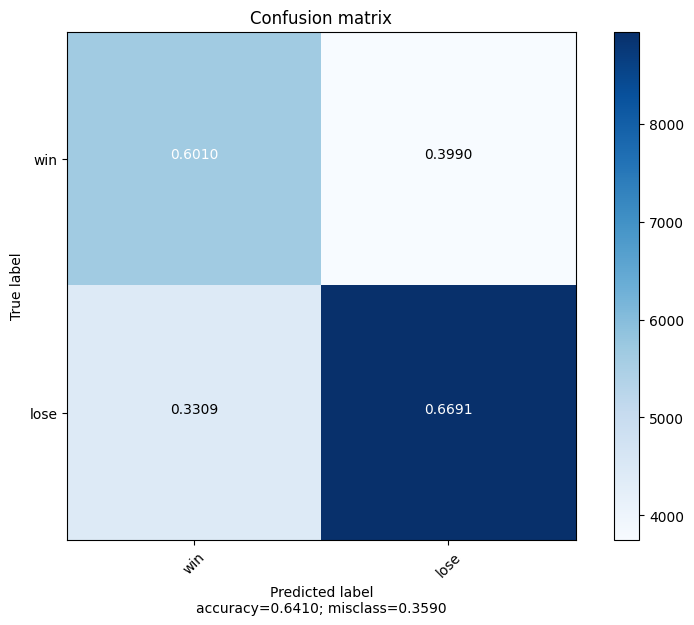

In [18]:
cm = confusion_matrix(target, train_oof_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["train/confusion_matrix"].upload(fig)


**OOF Classification report**

In [19]:
run["train/classification_report"] = classification_report(target, train_oof_binary)
print(classification_report(target, train_oof_binary))

              precision    recall  f1-score   support

           0       0.56      0.60      0.58      9397
           1       0.70      0.67      0.69     13370

    accuracy                           0.64     22767
   macro avg       0.63      0.64      0.63     22767
weighted avg       0.65      0.64      0.64     22767



**Train Feature Importance via Weight/Splits - the number of times a feature appears in a tree**

<AxesSubplot: title={'center': 'Top 25 Feature importance - weight'}, xlabel='F score', ylabel='Features'>

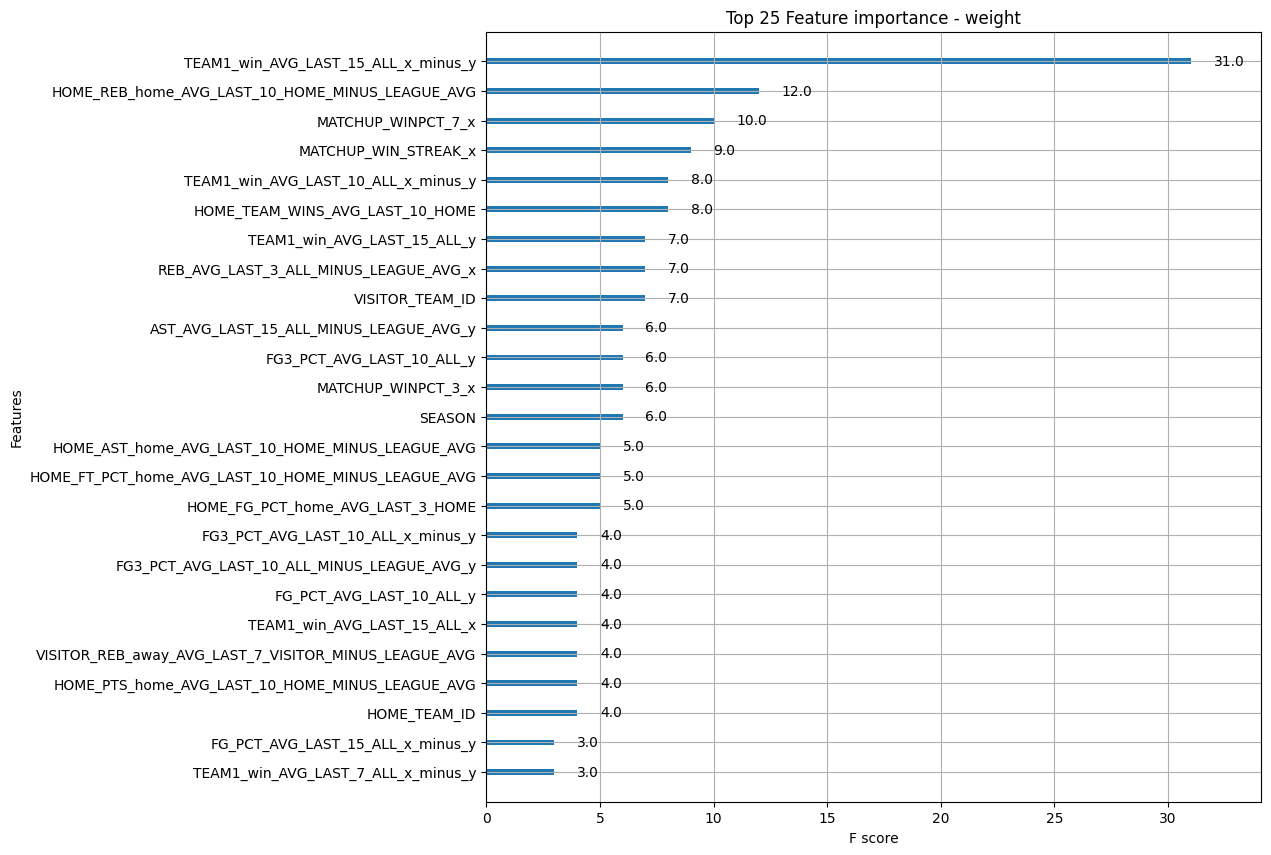

In [20]:
if MODEL_NAME == "xgboost":
    IMPORTANCE_TYPE = 'weight'
if MODEL_NAME == "lightgbm":
    IMPORTANCE_TYPE = 'split'

max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - ' + IMPORTANCE_TYPE
fig, ax = plt.subplots(1,1,figsize=(10,10))
BASE_MODEL.plot_importance(model, importance_type=IMPORTANCE_TYPE, max_num_features=max_features, title=max_title ,ax=ax)
#run["train/feature_importance_" + IMPORTANCE_TYPE].upload(fig)

**Train Feature Importance via Gain - the average gain of splits which use the feature**

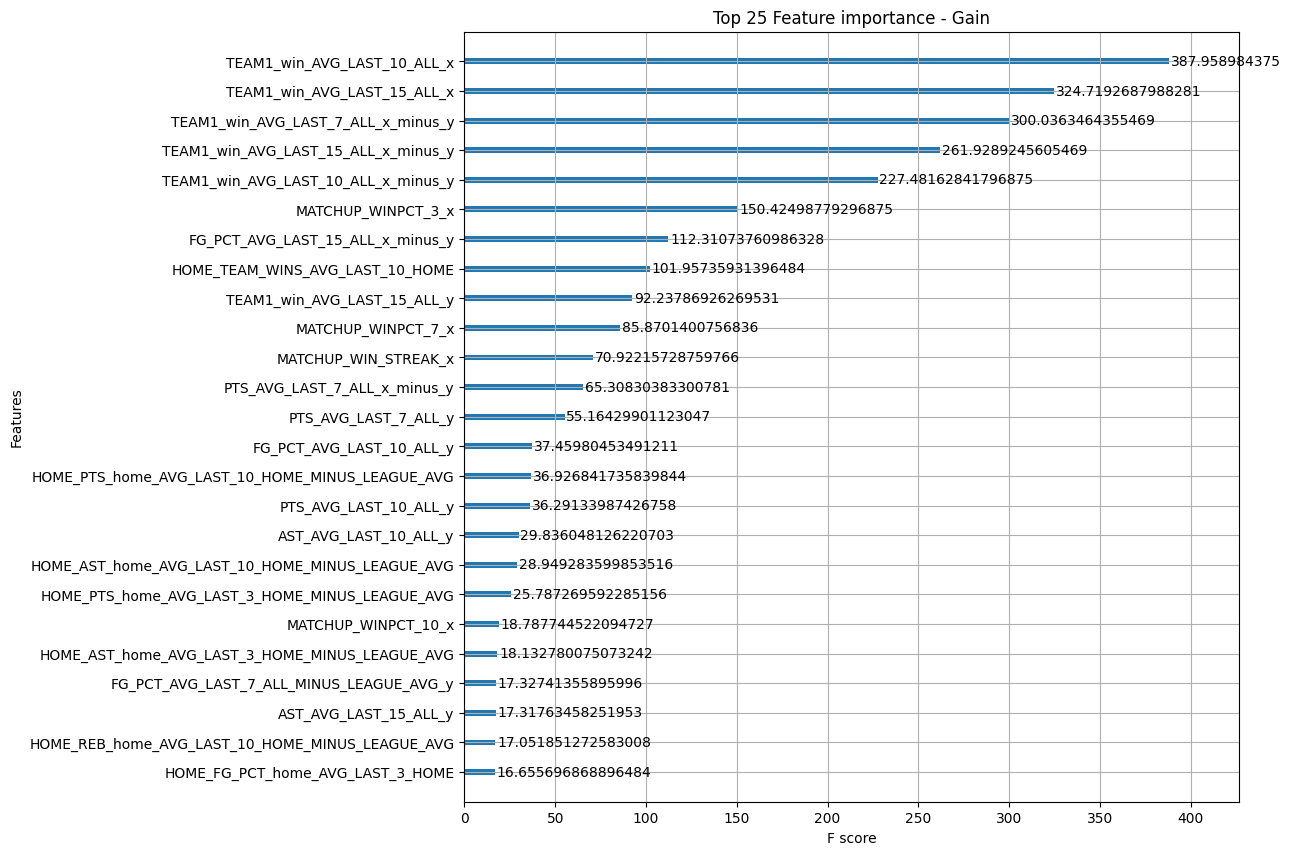

In [21]:
max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - Gain'
fig, ax = plt.subplots(1,1,figsize=(10,10))
BASE_MODEL.plot_importance(model, importance_type='gain', max_num_features=max_features, title=max_title ,ax=ax)
run["train/feature_importance_gain"].upload(fig)

**OOF Feature Importance via Shapley values**

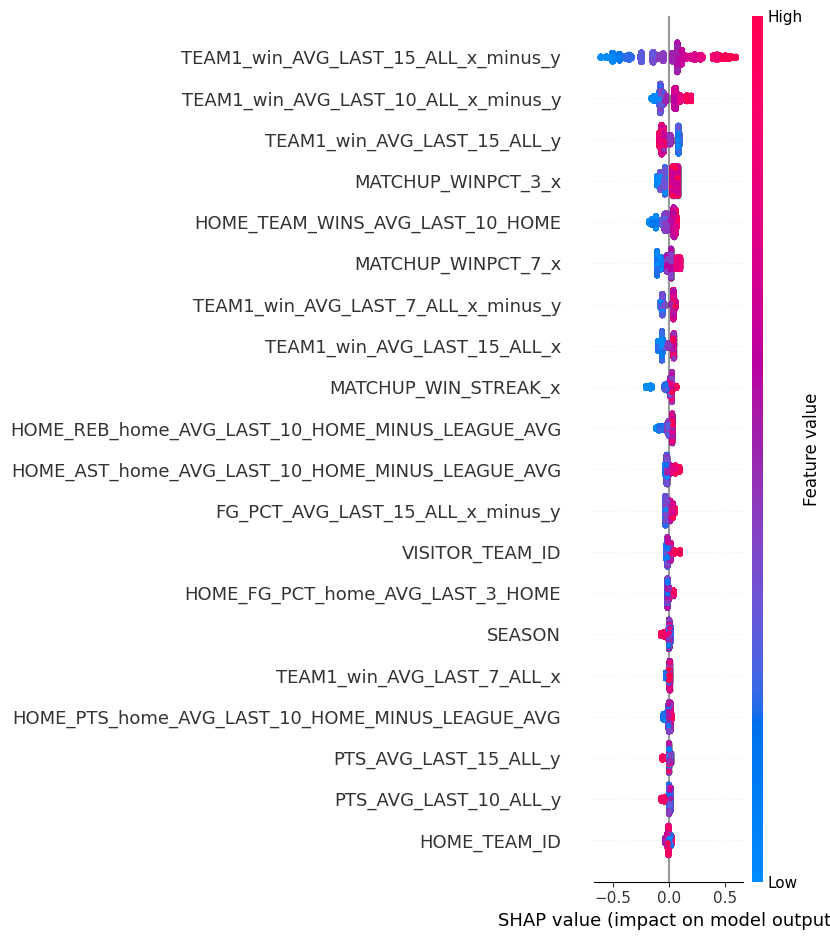

In [22]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train)
run["train/shapley_summary"].upload(fig)

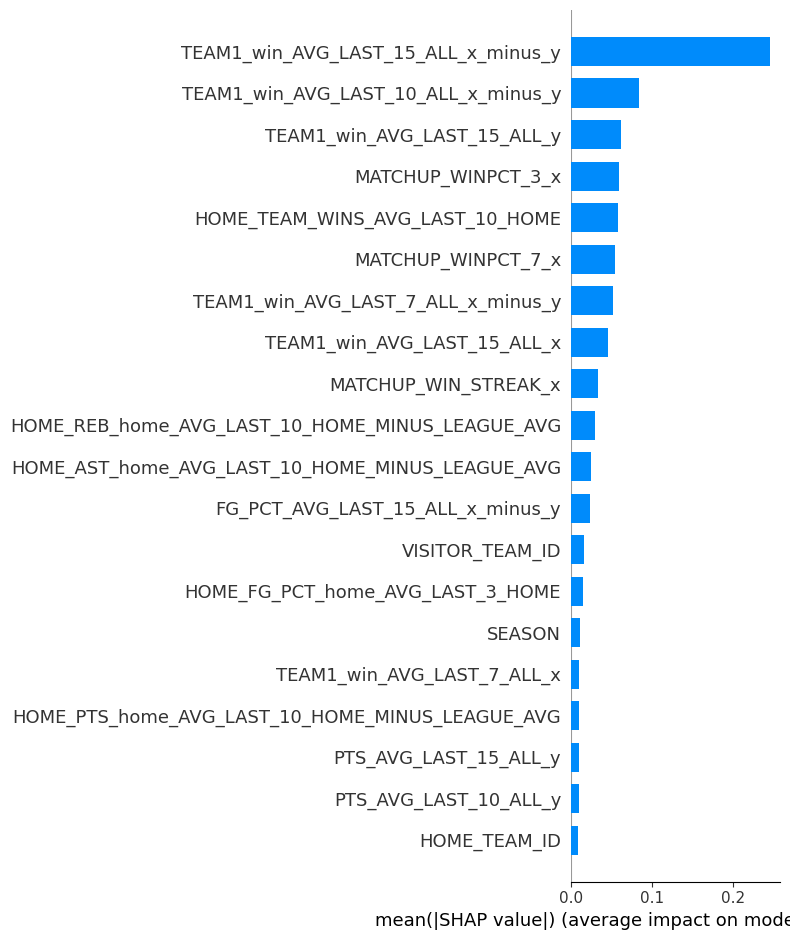

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")
run["train/shapley_summary_bar"].upload(fig)

**Save train data with predictions**


In [24]:
train['TARGET'] = target
train['PredictionPct'] = train_oof
train['Prediction'] = train_oof_binary
train.to_csv(DATAPATH / "train_predictions.csv",index=False)

### Test Data Evaluation

In [25]:
if MODEL_NAME == "xgboost":
    test_data = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)
if MODEL_NAME == "lightgbm":
    test_data = test

test_preds = model.predict(test_data)
test_preds_shap = get_shapley(MODEL_NAME, model, test_data)

test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

run["test/accuracy"] = acc_score 
run["test/AUC"] = auc_score 
run["test/optimal_threshold"] = optimal_threshold

df = {'Label': 'Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
results = results.append(df, ignore_index = True)   




Scores:

Accuracy Score: 0.615536862939139
AUC Score: 0.6570152168414614
Optimal Threshold: 0.8239167


**Save Model meta-data and pickled model**

These may be used for model registry apps

In [26]:
joblib.dump(model, 'model.pkl')

model_data = {
            #'model_name': MODEL_NAME + "_" + datetime.now().strftime('%Y-%m-%d'),
            'model_name': MODEL_NAME,
            'metrics':{'AUC': auc_score, 'Accuracy': acc_score },
            }
    
with open('model_data.json', 'w') as f:
    f.write(json.dumps(model_data))

**Test Confusion Matrix**

[[595 448]
 [329 649]]


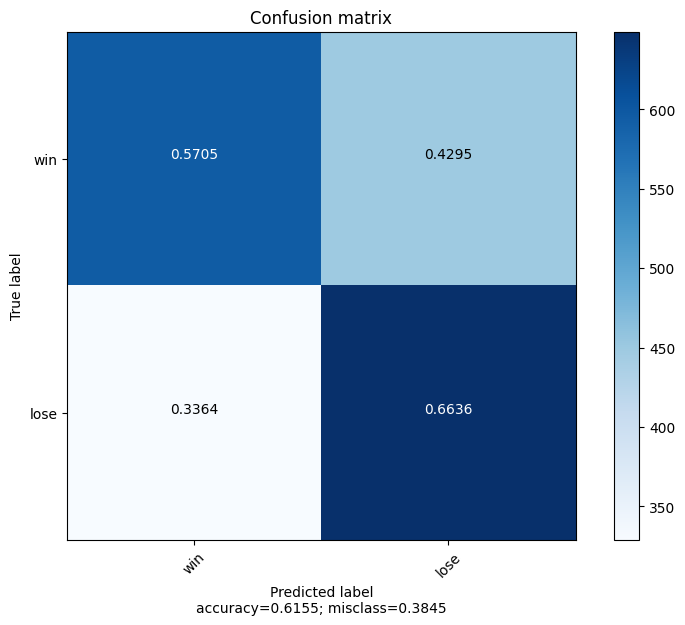

In [27]:
cm = confusion_matrix(test_target, test_preds_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["test/confusion_matrix"].upload(fig)


**Test Classification report**

In [28]:
run["test/classification_report"] = classification_report(test_target, test_preds_binary)
print(classification_report(test_target, test_preds_binary))

              precision    recall  f1-score   support

           0       0.64      0.57      0.60      1043
           1       0.59      0.66      0.63       978

    accuracy                           0.62      2021
   macro avg       0.62      0.62      0.62      2021
weighted avg       0.62      0.62      0.61      2021



**Test Feature Importance via Shapley values**

For comparison to cross-validation OOF Shapley values to ensure that the model is working in similar manner on the test data as train data

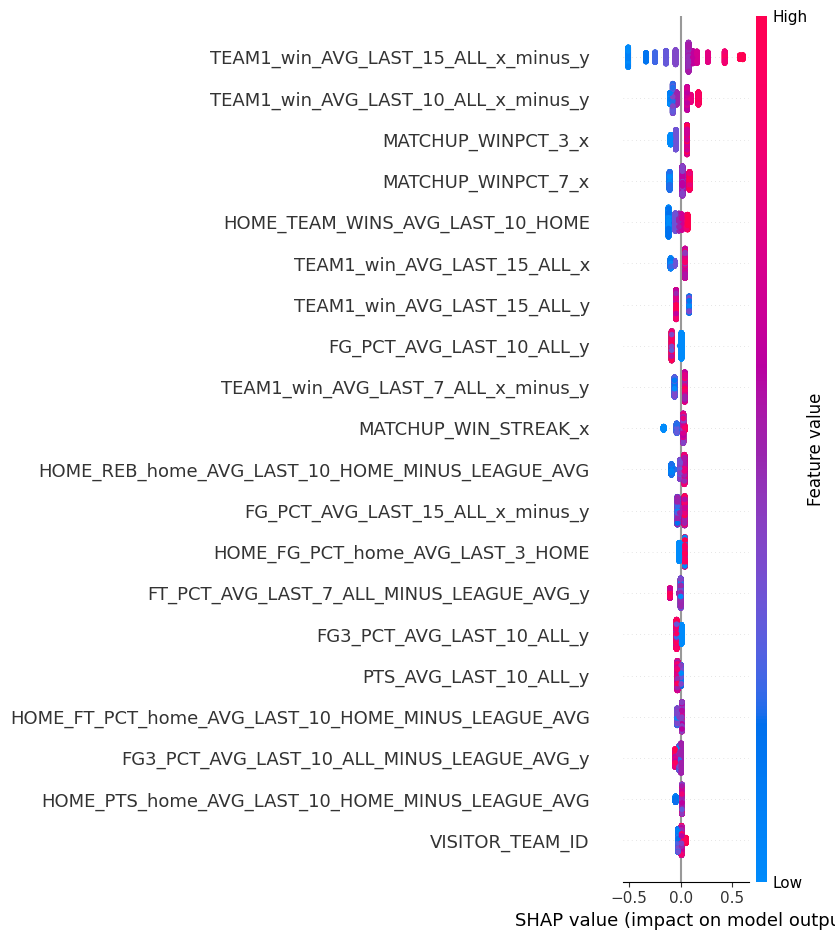

In [29]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test)
run["test/shapley_summary"].upload(fig)

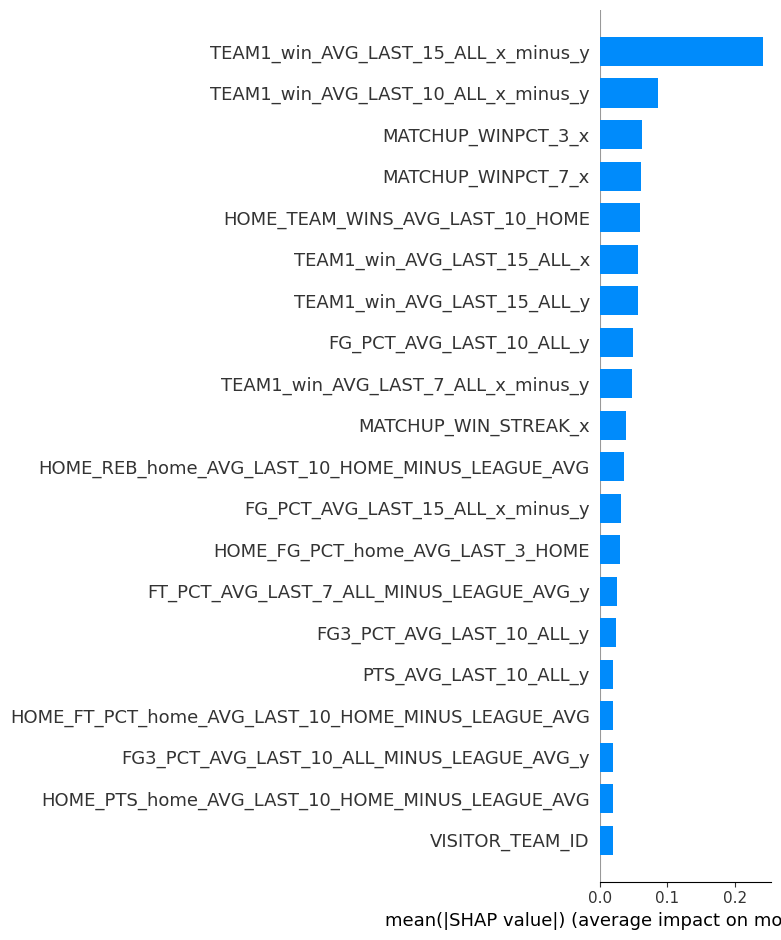

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(test_preds_shap[:,:-1], test[use_columns], plot_type="bar")
run["test/shapley_summary_bar"].upload(fig)

**Save test data with predictions**


In [31]:
test['TARGET'] = test_target
test['PredictionPct'] = test_preds
test['Prediction'] = test_preds_binary
test.to_csv(DATAPATH / "test_predictions.csv",index=False)

## Model Evaluation

 - Compare Simple model predictions vs ML Test data predictions
 - Compare OOF/Train data vs Test/Validation data
 - Compare early season Test data vs later season Test data
 
 Feature importances via Shapley values are *local* to the given dataset and can assist in adversarial validation

**Split Test data**

Compare the model performance on the early part of the test data vs the later part of the test data

In [32]:
test = pd.read_csv(DATAPATH / TEST_NAME)
test = fix_datatypes(test)
test = encode_categoricals(test)

SPLIT = pd.to_datetime("2023-01-01")

run["test_split_Test1/end_date"] = SPLIT
run["test_split_Test2/start_date"] = SPLIT

test1 = test[test['GAME_DATE_EST'] < SPLIT]
test2 = test[test['GAME_DATE_EST'] >= SPLIT]

test1_target = test1['TARGET']
test2_target = test2['TARGET']

test1 = test1[use_columns]
test2 = test2[use_columns]

In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Columns: 245 entries, GAME_DATE_EST to REB_AVG_LAST_15_ALL_x_minus_y
dtypes: datetime64[ns](1), float16(222), int32(1), int8(21)
memory usage: 941.5 KB


**Process Splits**

TEST1

Scores:

Accuracy Score: 0.6199324324324325
AUC Score: 0.6599123670536657
Optimal Threshold: 0.8460669
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       904
           1       0.62      0.60      0.61       872

    accuracy                           0.62      1776
   macro avg       0.62      0.62      0.62      1776
weighted avg       0.62      0.62      0.62      1776



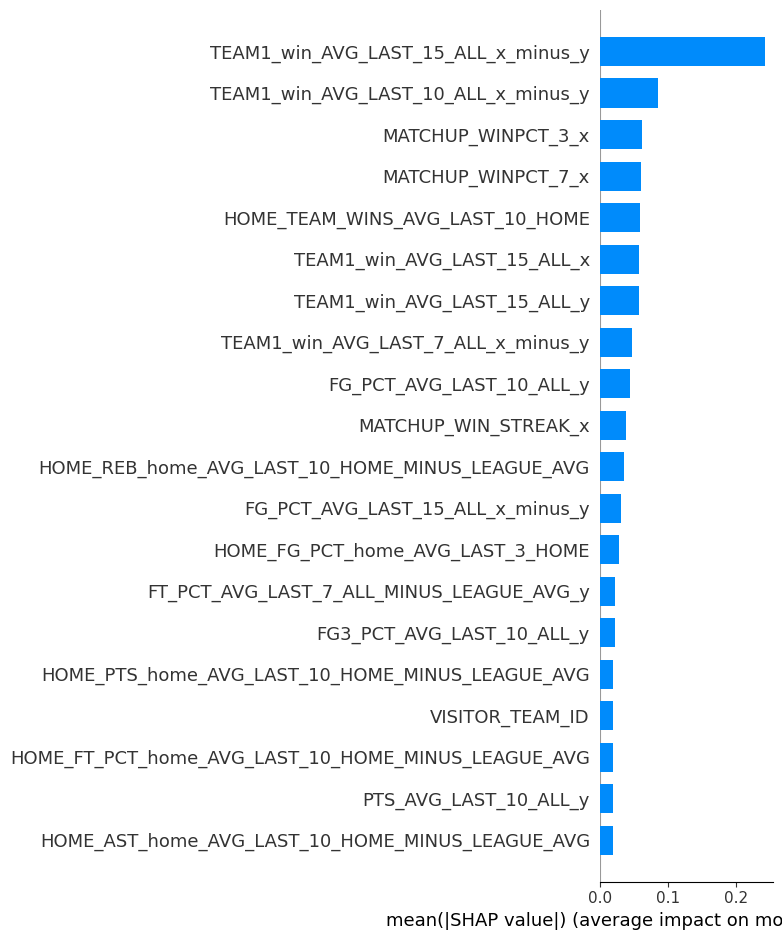

TEST2

Scores:

Accuracy Score: 0.6
AUC Score: 0.6203339215420116
Optimal Threshold: 0.81160325
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       139
           1       0.54      0.58      0.55       106

    accuracy                           0.60       245
   macro avg       0.60      0.60      0.60       245
weighted avg       0.60      0.60      0.60       245



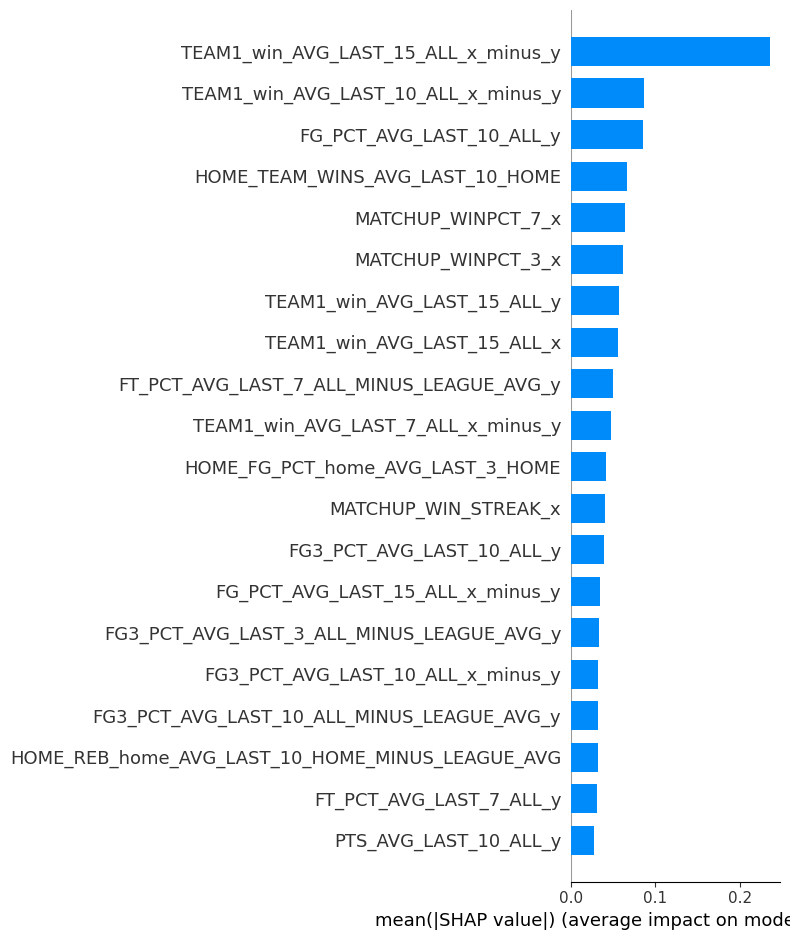

In [34]:
def process_splits(label, test, test_target, results):

    if MODEL_NAME == "xgboost":
        test_data = xgb.DMatrix(test, enable_categorical=ENABLE_CATEGORICAL)
    if MODEL_NAME == "lightgbm":
        test_data = test

    test_preds = model.predict(test_data)
    test_preds_shap = get_shapley(MODEL_NAME, model, test_data)

    test_preds_binary, acc_score, auc_score, optimal_threshold = get_scores(test_target, test_preds)

    run["test_split_" + label + "/accuracy"] = acc_score 
    run["test_split_" + label + "/AUC"] = auc_score 
    run["test_split_" + label + "/optimal_threshold"] = optimal_threshold

    df = {'Label': label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':optimal_threshold}
    results = results.append(df, ignore_index = True) 

    run["test_split_" + label + "/classification_report"] = classification_report(test_target, test_preds_binary)
    print(classification_report(test_target, test_preds_binary))
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    shap.summary_plot(test_preds_shap[:,:-1], test, plot_type="bar")
    #run["test_split_" + label + "/shapley_summary_bar"].upload(fig)

    #Simple model applied to split
    acc_score, auc_score = SimpleModel(test, test_target)
    df = {'Label': 'Simple-' + label, 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
    results = results.append(df, ignore_index = True) 
    
    return test_preds_shap, results
    
print("TEST1")
test_preds_shap1, results = process_splits('Test1',test1, test1_target, results)
print("TEST2")
test_preds_shap2, results = process_splits('Test2',test2, test2_target, results)


**Summary Table**

Key metrics from Simple Model, Train, Test, and Test-split

In [35]:
acc_score1  = results.loc[results['Label'] == 'Train', 'Accuracy'].values[0]
acc_score2  = results.loc[results['Label'] == 'Test', 'Accuracy'].values[0]
acc_score = acc_score1 - acc_score2
auc_score1  = results.loc[results['Label'] == 'Train', 'AUC'].values[0]
auc_score2  = results.loc[results['Label'] == 'Test', 'AUC'].values[0]
auc_score = auc_score1 - auc_score2

df = {'Label': 'Train-Test', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 

run["evaluation/train-test_accuracy"] = acc_score
run["evaluation/train-test_AUC"] = auc_score

acc_score1  = results.loc[results['Label'] == 'Test1', 'Accuracy'].values[0]
acc_score2  = results.loc[results['Label'] == 'Test2', 'Accuracy'].values[0]
acc_score = acc_score1 - acc_score2
auc_score1  = results.loc[results['Label'] == 'Test1', 'AUC'].values[0]
auc_score2  = results.loc[results['Label'] == 'Test2', 'AUC'].values[0]
auc_score = auc_score1 - auc_score2

df = {'Label': 'Test1-Test2', 'Accuracy': acc_score, 'AUC': auc_score, 'Threshold':"N/A"}
results = results.append(df, ignore_index = True) 

run["evaluation/test1-test2_accuracy"] = acc_score
run["evaluation/test1-test2_AUC"] = auc_score

run["evaluation/summary_table"].upload(File.as_html(results))
results

,Label,Accuracy,AUC,Threshold
0,Simple Model,0.483919,0.500000,N/A
1,Train,0.641016,0.687376,0.844164
2,Test,0.615537,0.657015,0.823917
3,Test1,0.619932,0.659912,0.846067
4,Simple-Test1,0.490991,0.500000,N/A
5,Test2,0.600000,0.620334,0.811603
6,Simple-Test2,0.432653,0.500000,N/A
7,Train-Test,0.025479,0.030361,N/A
8,Test1-Test2,0.019932,0.039578,N/A


**Train vs Test Feature Importances via Shapley Values**

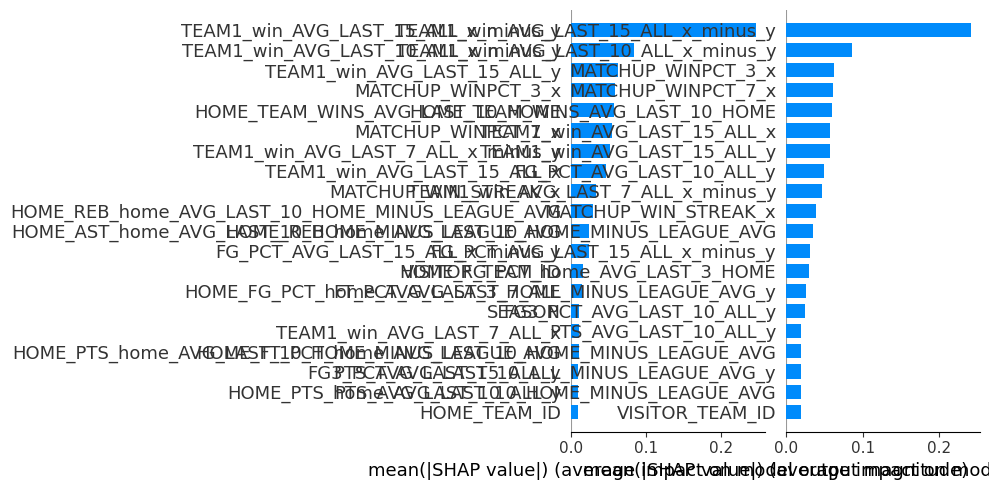

In [36]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
#run["evaluation/test_train_shapley_summary_bar"].upload(fig)

**Test1 vs Test2 Feature Importances via Shapley Values**

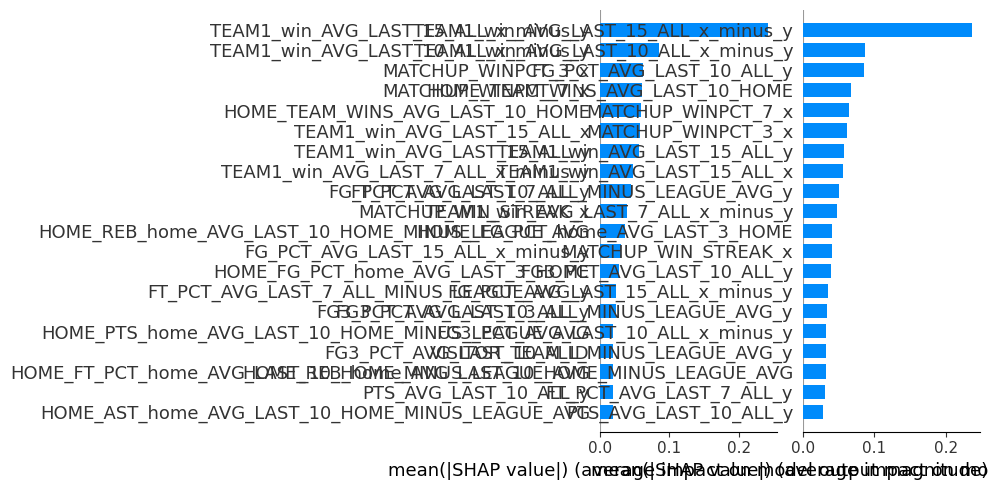

In [37]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
shap.summary_plot(test_preds_shap1[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.subplot(1,2,2)
shap.summary_plot(test_preds_shap2[:,:-1], test1[use_columns], plot_type="bar", plot_size=None, show=False)
plt.tight_layout()
fig.show()
#run["evaluation/test1_test2_shapley_summary_bar"].upload(fig)

**End experiment tracking**

In [38]:
#end experiment tracking
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 89 operations to synchronize with Neptune. Do not kill this process.
All 89 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-105


**Save Tuned Hyperparameters**

Optional function - when run, it overwrites the current "best" hyperparameters with the newly generated hyperparameters. Some descretion is required.

In [39]:
def save_tuned_params(MODEL_NAME, tuned_params):
    with open(MODEL_NAME + '.json', 'w') as f:
        f.write(json.dumps(tuned_params))
        
save_tuned_params(MODEL_NAME, tuned_params)

**Visualize Data Comparisons**

In [40]:
# run Sweetviz comparing test data that led to a correct prediction vs incorrect prediction

test = pd.read_csv(DATAPATH / 'test_predictions.csv')

test['TARGET'] = test['TARGET'].astype('int8')
test['Prediction'] = test['Prediction'].astype('int8')

test_correct = test[test['TARGET'] == test['Prediction']]
test_wrong = test[test['TARGET'] != test['Prediction']]

#run_sweetviz_comparison(test_correct, 'Test-Correct', test_wrong, 'Test-Wrong', 'Prediction', 'correct-incorrect')

## Notes



The output for each run is saved at Neptune.ai at the following link: https://app.neptune.ai/cmunch1/nba-prediction/experiments?split=tbl&dash=charts&viewId=979e20ed-e172-4c33-8aae-0b1aa1af3602



